https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from time import time
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import torch
from torch.utils.data import Dataset, TensorDataset, IterableDataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math

In [17]:
warnings.filterwarnings("ignore")

#### Data loading

In [18]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
# Convertir fecha_hora_retiro a datetime
df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))

#limpieza de datos
fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite].copy()
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count().resample('D').sum()

df_trimmed = df_shorten[df_shorten['date'] <= pd.to_datetime('2017-12-01 23:59:59')].copy()
bicis_por_dia_trimmed = df_trimmed.groupby('date').bici_id_usuario.count().resample('D').sum()

X = bicis_por_dia_trimmed
X = pd.DataFrame(X)
#X = X.reset_index()

timeseries = X['bici_id_usuario'].values.astype('float32')
timeseries = timeseries.reshape(-1, 1)

#### Split into train and test

In [19]:
training_data_len = math.ceil(len(X) * .8)
training_data_len
 
#Splitting the dataset
train_data = X[:training_data_len].iloc[:,:1]
test_data = X[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(391, 1) (97, 1)


In [24]:
train_data.columns

Index(['bici_id_usuario'], dtype='object')

In [25]:
# Selecting Open Price values
dataset_train = train_data.bici_id_usuario.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(391, 1)

In [27]:
# Selecting Open Price values
dataset_test = test_data.bici_id_usuario.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(97, 1)

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.253206  ]
 [0.2957708 ]
 [0.30013643]
 [0.3271487 ]
 [0.23437926]]
[0.24581176] [0.6655498] [0.51507767] [0.78647578] [0.75814804]


In [63]:
# Create sequences and labels for training data
sequence_length = 30  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
#print(X_train)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([361, 30, 1]), torch.Size([361, 30, 1]))

In [64]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([67, 30, 1]), torch.Size([67, 30, 1]))

In [65]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [67]:
input_size = 1
num_layers = 2
hidden_size = 50
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [68]:
batch_size = 1
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
num_epochs = 100
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/100] - Training Loss: 0.0054, Test Loss: 0.0514
Epoch [20/100] - Training Loss: 0.0033, Test Loss: 0.0481
Epoch [30/100] - Training Loss: 0.0029, Test Loss: 0.0491
Epoch [40/100] - Training Loss: 0.0027, Test Loss: 0.0489
Epoch [50/100] - Training Loss: 0.0024, Test Loss: 0.0517
Epoch [60/100] - Training Loss: 0.0025, Test Loss: 0.0485
Epoch [70/100] - Training Loss: 0.0022, Test Loss: 0.0466
Epoch [80/100] - Training Loss: 0.0021, Test Loss: 0.0501
Epoch [90/100] - Training Loss: 0.0020, Test Loss: 0.0496
Epoch [100/100] - Training Loss: 0.0019, Test Loss: 0.0517


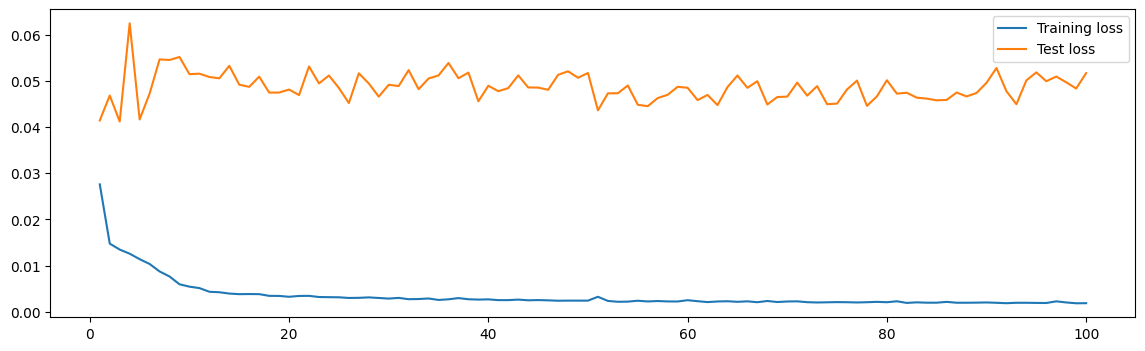

In [70]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [71]:
# Define the number of future time steps to forecast
num_forecast_steps = 30
 
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
         
# Generate futute dates
last_date = test_data.index[-1]
 
# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

(30,)


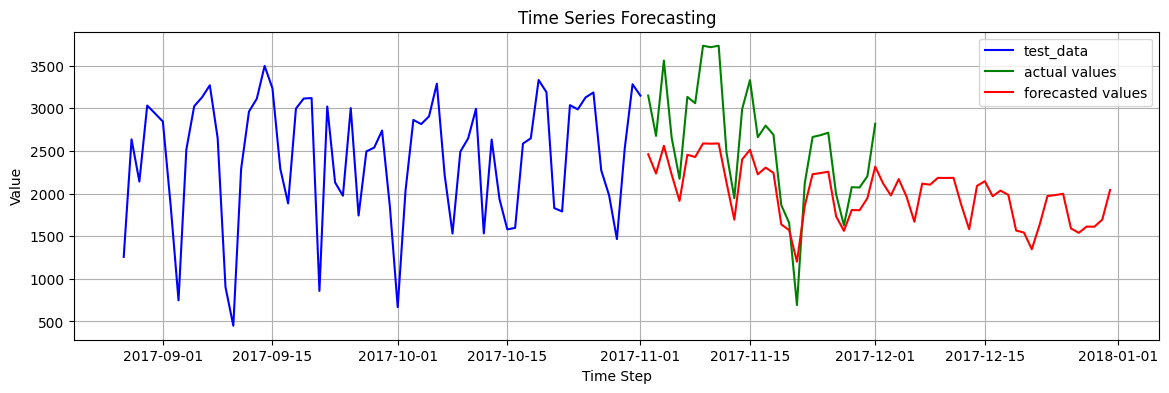

In [72]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 
 
 
#Test data
plt.plot(test_data.index[-100:-30], test_data.bici_id_usuario[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 
 
#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')  
 
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
